## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

## 2  — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve each idiom containing the word.
Add the idiom Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-idiom match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


## 5 — Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10 and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [1051]:
test_image_topic=  'two'
image_topic = test_image_topic

In [1052]:
import pandas as pd
from collections import namedtuple
import uuid

## -1  — Webscrape and process phrases (idioms, sayings, aphorisms)

They should be converted into lists of phonetic sounds

## 0  — Load `phrase_dict` pickled and processed after being scraped

#### Data structures defined

In [1053]:

Phrase = namedtuple('Phrase',['text_string', 'word_list','phon_list','string_length', 'word_count', 'prefix', 'phrase_type'])
phrase_dict = dict()

Close_word = namedtuple('Close_word', ['word', 'distance'])

Sem_family = namedtuple('Sem_family', ['locus_word', 'sem_fam_words'])

Phon_family = namedtuple('Phon_family', ['locus_word', 'close_words'])

#### Temporary toy example of the dict of phrases, to be replaced with idioms etc. scraped from web

In [1054]:
def seed_the_phrase_dictionary_with_examples():
    t_string = 'smarter than the average bear'
    w_list = t_string.lower().split()
    ph_id1 = uuid.uuid1()
    phrase_dict[ph_id1] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'not a hair out of place'
    w_list = t_string.lower().split()
    ph_id2 = uuid.uuid1()
    phrase_dict[ph_id2] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'three blind mice'
    w_list = t_string.lower().split()
    ph_id3 = uuid.uuid1()
    phrase_dict[ph_id3] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'i just called to say I love you'
    w_list = t_string.lower().split()
    ph_id4 = uuid.uuid1()
    phrase_dict[ph_id4] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'up, up in the air'
    w_list = t_string.lower().split()
    ph_id5 = uuid.uuid1()
    phrase_dict[ph_id5] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'wouldn\'t it be nice'
    w_list = t_string.lower().split()
    ph_id6 = uuid.uuid1()
    phrase_dict[ph_id6] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'roses are red, violets are blue'
    w_list = t_string.lower().split()
    ph_id7 = uuid.uuid1()
    phrase_dict[ph_id7] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

seed_the_phrase_dictionary_with_examples()

In [1055]:
phrase_dict

{UUID('1ab0c26c-8282-11eb-abae-acde48001122'): Phrase(text_string='smarter than the average bear', word_list=['smarter', 'than', 'the', 'average', 'bear'], phon_list=['smarter', 'than', 'the', 'average', 'bear'], string_length=29, word_count=5, prefix='As usual: ', phrase_type='idiom'),
 UUID('1ab0c370-8282-11eb-abae-acde48001122'): Phrase(text_string='not a hair out of place', word_list=['not', 'a', 'hair', 'out', 'of', 'place'], phon_list=['not', 'a', 'hair', 'out', 'of', 'place'], string_length=23, word_count=6, prefix='As usual: ', phrase_type='idiom'),
 UUID('1ab0c3b6-8282-11eb-abae-acde48001122'): Phrase(text_string='three blind mice', word_list=['three', 'blind', 'mice'], phon_list=['three', 'blind', 'mice'], string_length=16, word_count=3, prefix='As usual: ', phrase_type='idiom'),
 UUID('1ab0c4a6-8282-11eb-abae-acde48001122'): Phrase(text_string='i just called to say I love you', word_list=['i', 'just', 'called', 'to', 'say', 'i', 'love', 'you'], phon_list=['i', 'just', 'calle

In [1056]:
# change this so that it imports into a pandas dataframe, so that we can import conversational 
# prefixes and suffixes manually editied in Excel

import csv
#idiom_list = [] # Won't be needed

def compile_idiom_lists():
    idiom_list_ = []
    with open('data/idioms_1500.csv', 'r') as idioms_data: 
        for line in csv.reader(idioms_data):
            idiom_list_.extend(line)
    idiom_list_ = idiom_list_[1:]
    return idiom_list_
    
idiom_list = compile_idiom_lists()


In [1057]:
def build_phrase_dictionary(idiom_list_):
    for idiom_str in idiom_list_:
        w_list = idiom_str.lower().split()
        phrase_dict[uuid.uuid1()] = Phrase(text_string = idiom_str, word_list = w_list, phon_list = w_list, string_length = len(idiom_str), word_count = len(w_list), prefix="Yeah, right, like  ", phrase_type='idiom' )
    
build_phrase_dictionary()    

## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

In [1058]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions


%matplotlib inline

In [1059]:
def prepare_image_classification_model():
    model_ = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top=True)
    return model_

import requests
def get_image_category_labels():  # is this function even necessary?
    #fetching labels from Imagenet
    response=requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    imgnet_map=response.json()
    imgnet_map   # {'0': ['n01440764', 'tench'],   '1': ['n01443537', 'goldfish'], etc.
    
    imgnet_num_from_label = {v[1]:k for k, v in imgnet_map.items()}
    imgnet_label_from_num = {k:v[1] for k, v in imgnet_map.items()}

    return ( imgnet_num_from_label, imgnet_label_from_num ) 


In [1060]:
def get_num_str( num, max_digits=4 ):
    leading_zeros = int(max_digits - (np.trunc(np.log10(num))+1))
    return '0'*leading_zeros + str(num)

In [1061]:
import random

def get_image_path():
    path_prefix = 'data/ILSVRC/Data/DET/test/'
    filename_stem ='ILSVRC2017_test_0000'
    filename_suffix = '.JPEG'
    #random.seed()
    file_number = rand_num = np.random.randint(1, 5500)   
    IMAGE_PATH_ = path_prefix + filename_stem + get_num_str( rand_num ) + filename_suffix
    return IMAGE_PATH_
    
def preprocess_image( IMAGE_PATH_ ):
    img_ =tf.keras.preprocessing.image.load_img(IMAGE_PATH_, target_size=(299, 299))
    img_ =tf.keras.preprocessing.image.img_to_array(img_)
    # prepare to show and save image
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(img_/255.)
    plt.savefig('data/temp.png',bbox_inches='tight')
    return img_ # It seems futile to return this image

def process_and_classify_image( img_, model_):
    img_ = tf.keras.applications.xception.preprocess_input(img_)
    print( 'img.shape: ', img_.shape )
    prediction_array = model_.predict(np.array([img_]))
    return prediction_array

def extract_best_prediction( prediction_array_ ):
    prediction_decoded = decode_predictions(prediction_array_, top=5)
    print( prediction_decoded )
    best_prediction_str = prediction_decoded[0][0][1]
    return best_prediction_str
    

In [1062]:
#global_var_img = None

def image_recognition_pipeline( ):
    model = prepare_image_classification_model()
    #get_image_category_labels()
    IMAGE_PATH = get_image_path()
    img = preprocess_image( IMAGE_PATH )
    prediction_array = process_and_classify_image( img, model)
    image_topic_ = extract_best_prediction( prediction_array )
    image_topics_ = [image_topic_]
    #global_var_img = img
    return  img, image_topics_

img.shape:  (299, 299, 3)
[[('n06874185', 'traffic_light', 0.45695046), ('n04487081', 'trolleybus', 0.1701746), ('n04335435', 'streetcar', 0.10388858), ('n04252225', 'snowplow', 0.07023131), ('n02930766', 'cab', 0.042300805)]]


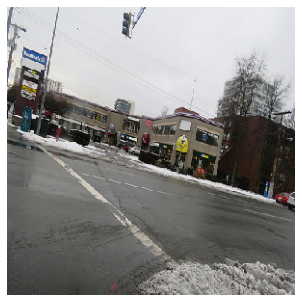

In [1063]:
recognized_image, image_topics  = image_recognition_pipeline( )

In [1064]:
#image_topic='dragonfly'

In [1065]:
#plt.imshow(recognized_image/255.)

## 2 — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

In [1066]:
from nltk.corpus import wordnet

def get_synonyms( w ):
    #L = [l.name() if '_' not in l.name() else l.name().split('_') for l in wordnet.synsets( w )[0].lemmas()]  # There may be other synonyms in the synset
    #flattened_list = [w if type()]
    #return L #flattened_list
    return [word for object_name in [syn.name().split('_') for syn in wordnet.synsets( w )[0].lemmas()] for word in object_name]

In [1067]:
get_synonyms( 'oystercatcher' )

['oystercatcher', 'oyster', 'catcher']

In [1068]:
wordnet.synsets( 'oystercatcher' )[0].lemmas()
#get_synonyms( 'ladybug')

[Lemma('oystercatcher.n.01.oystercatcher'),
 Lemma('oystercatcher.n.01.oyster_catcher')]

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

In [1069]:
#english_dictionary = ['two', 'pair', 'bear', 'scare', 'you', 'twice', 'hair', 'mice', 'speaker', 'book']

In [1070]:
# two_phon_fam = Phon_family(locus_word=Close_word('two', 3), close_words = [Close_word('you', 2.1)])
# two_phon_fam

# pair_phon_fam = Phon_family(locus_word=Close_word('pair', 5), close_words = [Close_word('bear', 1.5), Close_word('hair', 2.7)])
# pair_phon_fam

# twice_phon_fam = Phon_family(locus_word=Close_word('twice', 4.1), close_words = [Close_word('mice', 2.1)])
# twice_phon_fam

In [1071]:
from nltk.corpus import words

words_set = set( words.words())
english_dictionary = words_set

In [1072]:
import eng_to_ipa as ipa

def syllable_count_diff( w1, w2 ):
    return abs( ipa.syllable_count( w1 ) - ipa.syllable_count( w2 ))

def same_syllable_count( w1, w2 ):
    return syllable_count_diff(w1, w2) == 0

def close_syllable_count( w1, w2, threshold=2):
    return syllable_count_diff( w1, w2 ) <= threshold

In [1073]:
# Eventually will need to to filter for the word-frequency sweet-spot or at least for only Engllish words
# Possibly rewrite with a decororater so that it uses memoization to speed this up

# Rewrite this so it vectorizes the subtraction of the syllable counts

def get_sized_rhymes( w ):
    word_length_min = 2
    rhyme_list = ipa.get_rhymes( w )
    return [ [rhyme for rhyme  in rhyme_list if same_syllable_count( w, rhyme) and len(rhyme) >= word_length_min and rhyme in words_set]]
   

In [1074]:
#ipa.isin_cmu('xue')

In [1075]:
get_sized_rhymes('oyster')

[['cloister', 'foister', 'roister']]

In [1076]:
import fuzzy
import phonetics
import Levenshtein as lev

soundex = fuzzy.Soundex(4)
dmeta = fuzzy.DMetaphone()

In [1077]:
## Temporary stand-in function, to be replaced with one that computes phonetic distance

# https://stackabuse.com/phonetic-similarity-of-words-a-vectorized-approach-in-python/
# "Phonetic Similarity of Words: A Vectorized Approach in Python"

def phonetic_distance(w1, w2):
#     print('fuzzy soundex', lev.distance( soundex(w1), soundex(w2)) )
#     print('fuzzy dmeta  ', lev.distance( dmeta(w1)[0], dmeta(w2)[0]) )
#     print('phon dmet    ', lev.distance( phonetics.dmetaphone(w1)[0], phonetics.dmetaphone(w2)[0]) )
#     print('phon met     ', lev.distance( phonetics.metaphone(w1), phonetics.metaphone(w2)) )
#     print('fuzzy nysiis ', lev.distance( fuzzy.nysiis(w1), fuzzy.nysiis(w2)) )
#     print('phon nysiis  ', lev.distance( phonetics.nysiis(w1), phonetics.nysiis(w2)) )
#     soundex_dist = lev.distance( soundex(w1), soundex(w2))
    nysiis_dist = lev.distance( fuzzy.nysiis(w1), fuzzy.nysiis(w2))
    try:
        dmeta_dist  = lev.distance( dmeta(w1)[0], dmeta(w2)[0])
        return np.mean( np.array([  dmeta_dist, nysiis_dist]) )
    except:
        return nysiis_dist

In [1078]:
from random import random


# Are these three lines necessary?
two_fam_member_list = ['you']
pair_fam_member_list = ['bear', 'hair']
twice_fam_member_list = ['mice']

def make_phon_fam_for_sem_fam_member( w_record, thresh=3 ):
    w_phon_code = w_record.word # To be replaced with phonetic version if needed
    close_word_list = []
    rhyme_dist = .3
    non_rhyme_penalty = rhyme_dist + .3
    
    # Find words that are not necessarily rhyms but phonetically similar
    for word in words_set:
        phon_dist = phonetic_distance( word, w_record.word) 
        if (phon_dist <= thresh) and (word != w_record.word):
            close_word_list.append( Close_word(word.lower(), phon_dist + non_rhyme_penalty  ))
    

    rhyme_word_list = get_sized_rhymes( w_record.word )[0]
    
    # Find words that are rhymes
    for word in rhyme_word_list:
         close_word_list.append( Close_word(word, rhyme_dist) )
    
    
    return Phon_family(locus_word = w_record, close_words=close_word_list )
    
    

In [1079]:
# two_phon_fam = get_phon_fam_for_sem_fam_member( 'two' )
# pair_phon_fam = get_phon_fam_for_sem_fam_member( 'pair' )
# twice_phon_fam = get_phon_fam_for_sem_fam_member( 'twice' )


In [1080]:
## ALERT:  Need to incorporate the semantic distance somewhere

In [1081]:
# two_sem_fam = Sem_family(locus_word='two', phon_fams = [make_phon_fam_for_sem_fam_member( 'two' ), \
#                                                         make_phon_fam_for_sem_fam_member( 'pair' ), \
#                                                         make_phon_fam_for_sem_fam_member( 'twice' )])

In [1082]:
# To be replaced with Word2Vec `most_similar()`

# def get_most_similar_obsolete( w ):  
#     list_of_duples =  [('pair', .95), ('twice', .90)]
#     list_of_close_words = [Close_word( word=w_str, distance= 1 - w_sim) for w_str, w_sim in list_of_duples ]
        
#     return list_of_close_words

In [1083]:
def get_most_similar( w ):  
    synonym_dist_setting = .6
    list_of_duples = [(syn, synonym_dist_setting) for syn in get_synonyms( w )]
    if(w == 'two'):
        additional_words =  [('pair', .95), ('twice', .90)]
        list_of_duples.extend( additional_words )
    list_of_close_words = [Close_word( word=w_str, distance= w_sim) for w_str, w_sim in list_of_duples ]
        
    return list_of_close_words

In [1084]:
get_most_similar( 'oyster' )

[Close_word(word='oyster', distance=0.6)]

In [1085]:
def make_phon_fams_and_sem_family( w ):
    word_record_ = Close_word(w, 0.0)
    
    sem_sim_words = get_most_similar( w )  # Eventually replace with call to Word2Vec
    
    #phon_fams_list = [make_phon_fam_for_sem_fam_member( word_record_  )]
    phon_fams_list = []

    
    for close_w_record in sem_sim_words:
        print( close_w_record )
        phon_fams_list.append( make_phon_fam_for_sem_fam_member( close_w_record ) )
    
    return Sem_family(locus_word= word_record_, sem_fam_words = phon_fams_list)
   
 

In [1086]:
make_phon_fams_and_sem_family('soccer')

Close_word(word='soccer', distance=0.6)
Close_word(word='association', distance=0.6)
Close_word(word='football', distance=0.6)


Sem_family(locus_word=Close_word(word='soccer', distance=0.0), sem_fam_words=[Phon_family(locus_word=Close_word(word='soccer', distance=0.6), close_words=[Close_word(word='hickory', distance=2.6), Close_word(word='rumorous', distance=3.1), Close_word(word='cartier', distance=3.6), Close_word(word='geoduck', distance=3.6), Close_word(word='superhive', distance=3.1), Close_word(word='zincite', distance=3.6), Close_word(word='squacco', distance=3.1), Close_word(word='fictile', distance=3.6), Close_word(word='sarong', distance=3.6), Close_word(word='sexed', distance=3.1), Close_word(word='thecal', distance=3.1), Close_word(word='chudic', distance=3.6), Close_word(word='studium', distance=3.6), Close_word(word='mydaidae', distance=3.6), Close_word(word='phosphoruria', distance=3.6), Close_word(word='stadic', distance=3.6), Close_word(word='sillock', distance=2.6), Close_word(word='gorer', distance=2.6), Close_word(word='somnify', distance=3.6), Close_word(word='ratafia', distance=3.6), Clos

In [1087]:
# two_sem_fam = make_phon_fams_and_sem_family('two')
# two_sem_fam

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve phrases containing the word.
Add the phrase_Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-phrase match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


In [1088]:
get_most_similar('soccer')

[Close_word(word='soccer', distance=0.6),
 Close_word(word='association', distance=0.6),
 Close_word(word='football', distance=0.6)]

## TO CODE NEXT

Write code that takes the word `twice` and returns its `semantic_family` which is a list of words 
('pair', and 'twice' in this case) and returns either (TBD) the list phonetically similar words or 
the pboneticized version of the word to be compared with the phoneticized variants of words in
the phrases



#### Define dataframe for candidate phrases

In [1089]:
# col_names = ['semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist', 'phrase_id', 'dist_score']

# cand_df = pd.DataFrame(columns= col_names)
# cand_df

Empty DataFrame
Columns: [semantic_match, sem_dist, phonetic_match, phon_dist, phrase_id, dist_score]
Index: []

#### Need to write body of function that will convert to phoneticized version of word

In [1090]:
def phoneticized( w ):
    return w

### ALERT:  Instead, pre-generate a dictionary of phoneticized versions of the words in the list of idioms. Each phonetic word should map to a list of duples each of which is a phrase id and the corresponding word

In [1091]:
def get_matching_phrases( w ):
    matched_id_list = []
    for phrase_id in phrase_dict.keys():
        if w in phrase_dict[phrase_id].phon_list:
            matched_id_list.append(phrase_id)
            print( phrase_dict[ phrase_id] )
            return matched_id_list

In [1092]:
get_matching_phrases('oyster') 

Phrase(text_string='the world is your oyster', word_list=['the', 'world', 'is', 'your', 'oyster'], phon_list=['the', 'world', 'is', 'your', 'oyster'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')


[UUID('1ab53d10-8282-11eb-abae-acde48001122')]

In [1093]:
#  cycles through each phonetic family in the semantic family to get matching phrases

#def get_phrases_for_phon_fam( phon_fam_, sem_dist_ ):
def get_phrases_for_phon_fam( phon_fam_ ):

    word_match_records_ = []

    #phon_fam_ = pair_phon_fam
    for word in phon_fam_.close_words:
        matched_phrases = get_matching_phrases( word.word )
        #print(word, len(matched_phrases))
        if matched_phrases:
            for p_id in matched_phrases:
                word_match_records_.append({'semantic_match': phon_fam_.locus_word.word, 'sem_dist': phon_fam_.locus_word.distance, 'phonetic_match': word.word, 'phon_dist': word.distance, 'phrase_id': p_id, 'dist_score': ''})
    return word_match_records_ 


In [1094]:
def get_phrases_for_sem_fam( sem_fam_ ):
    word_match_records_ = []
    for phon_fam_ in sem_fam_.sem_fam_words:
        print( phon_fam_.locus_word.distance )
        #word_match_records_.extend( get_phrases_for_phon_fam( phon_fam_, sem_fam_.locus_word.distance ) )
        phrases_ = get_phrases_for_phon_fam( phon_fam_ ) 

        if len( phrases_ ) > 0:
            print( phrases_ )
            word_match_records_.extend( phrases_ )
    return word_match_records_

In [1095]:
# word_match_records = []   

# word_match_records.extend( get_phrases_for_phon_fam( two_phon_fam ) ) 
# word_match_records.extend( get_phrases_for_phon_fam( pair_phon_fam ) )
# word_match_records.extend( get_phrases_for_phon_fam( twice_phon_fam ) )  
# word_match_records

In [1096]:
#cand_df = cand_df.append(word_match_records)

In [1097]:
#two_sem_fam

In [1098]:
# word_match_records = get_phrases_for_sem_fam( two_sem_fam )
# word_match_records

In [1099]:
# To be replaced with image recognition algorithms
def get_image_topics():
    return [image_topic]
    #return [test_image_topic]

## The equivalent of `main` for the time being, until two or more image topics are handled

In [1100]:
#image_topics_list = []
#image_topic_word = ''

#def generate_the_caption(cand_df_, image_topics_list_, image_topic_word_):
#def generate_the_caption(cand_df_ ):
def generate_the_caption( image_topics_ ):  
    col_names = ['semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist', 'phrase_id', 'dist_score']
    cand_df_ = pd.DataFrame(columns= col_names)
    #cand_df
    
#    image_topics_list_     = get_image_topics()
#    image_topic_word_ = image_topics_list_[0]
    #image_topic_word = 'boy'

    image_topic_word_ = image_topics_[0]
    image_sem_fam = make_phon_fams_and_sem_family( image_topic_word_ )
    #two_sem_fam

    word_match_records = get_phrases_for_sem_fam( image_sem_fam )

    cand_df_ = cand_df_.append(word_match_records)
    return cand_df_, image_topic_word_

cand_df, image_topic_word = generate_the_caption(image_topics)
#cand_df, image_topics_list, image_topic_word = generate_the_caption(cand_df)

Close_word(word='traffic', distance=0.6)
Close_word(word='light', distance=0.6)
Close_word(word='traffic', distance=0.6)
Close_word(word='signal', distance=0.6)
Close_word(word='stoplight', distance=0.6)
0.6
Phrase(text_string='train wreck', word_list=['train', 'wreck'], phon_list=['train', 'wreck'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='drive a hard bargain', word_list=['drive', 'a', 'hard', 'bargain'], phon_list=['drive', 'a', 'hard', 'bargain'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='window dressing', word_list=['window', 'dressing'], phon_list=['window', 'dressing'], string_length=15, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='strike a chord', word_list=['strike', 'a', 'chord'], phon_list=['strike', 'a', 'chord'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string

Phrase(text_string='think big', word_list=['think', 'big'], phon_list=['think', 'big'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='no shit, sherlock', word_list=['no', 'shit,', 'sherlock'], phon_list=['no', 'shit,', 'sherlock'], string_length=17, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all in a day’s work (excl', word_list=['all', 'in', 'a', 'day’s', 'work', '(excl'], phon_list=['all', 'in', 'a', 'day’s', 'work', '(excl'], string_length=25, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='it’s all greek to me', word_list=['it’s', 'all', 'greek', 'to', 'me'], phon_list=['it’s', 'all', 'greek', 'to', 'me'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rookie mistake', word_list=['rookie', 'mistake'], phon_list=['rookie', 'mistake'], string_length=14, word_count=2, prefix='Yeah, right, like  ',

Phrase(text_string='all talk and no trousers', word_list=['all', 'talk', 'and', 'no', 'trousers'], phon_list=['all', 'talk', 'and', 'no', 'trousers'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='by hook or by crook', word_list=['by', 'hook', 'or', 'by', 'crook'], phon_list=['by', 'hook', 'or', 'by', 'crook'], string_length=19, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='give someone an earful', word_list=['give', 'someone', 'an', 'earful'], phon_list=['give', 'someone', 'an', 'earful'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='beat the drum for (something)', word_list=['beat', 'the', 'drum', 'for', '(something)'], phon_list=['beat', 'the', 'drum', 'for', '(something)'], string_length=29, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='show one’s true colors', word_list=['show', 'one’s', 'tr

Phrase(text_string='rake (someone) over the coals', word_list=['rake', '(someone)', 'over', 'the', 'coals'], phon_list=['rake', '(someone)', 'over', 'the', 'coals'], string_length=29, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
[{'semantic_match': 'traffic', 'sem_dist': 0.6, 'phonetic_match': 'train', 'phon_dist': 3.1, 'phrase_id': UUID('1ab54cd8-8282-11eb-abae-acde48001122'), 'dist_score': ''}, {'semantic_match': 'traffic', 'sem_dist': 0.6, 'phonetic_match': 'drive', 'phon_dist': 3.1, 'phrase_id': UUID('1ab496c6-8282-11eb-abae-acde48001122'), 'dist_score': ''}, {'semantic_match': 'traffic', 'sem_dist': 0.6, 'phonetic_match': 'dressing', 'phon_dist': 3.6, 'phrase_id': UUID('1ab55ce6-8282-11eb-abae-acde48001122'), 'dist_score': ''}, {'semantic_match': 'traffic', 'sem_dist': 0.6, 'phonetic_match': 'strike', 'phon_dist': 3.1, 'phrase_id': UUID('1ab51e5c-8282-11eb-abae-acde48001122'), 'dist_score': ''}, {'semantic_match': 'traffic', 'sem_dist': 0.6, 'phonetic_match': '

Phrase(text_string='an axe', word_list=['an', 'axe'], phon_list=['an', 'axe'], string_length=6, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='knock some sense into', word_list=['knock', 'some', 'sense', 'into'], phon_list=['knock', 'some', 'sense', 'into'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a guinea pig', word_list=['a', 'guinea', 'pig'], phon_list=['a', 'guinea', 'pig'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='blow hot and cold', word_list=['blow', 'hot', 'and', 'cold'], phon_list=['blow', 'hot', 'and', 'cold'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bolt from the blue', word_list=['bolt', 'from', 'the', 'blue'], phon_list=['bolt', 'from', 'the', 'blue'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_strin

Phrase(text_string='couch potato', word_list=['couch', 'potato'], phon_list=['couch', 'potato'], string_length=12, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='get the third degree', word_list=['get', 'the', 'third', 'degree'], phon_list=['get', 'the', 'third', 'degree'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='my way or the highway', word_list=['my', 'way', 'or', 'the', 'highway'], phon_list=['my', 'way', 'or', 'the', 'highway'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='banner year', word_list=['banner', 'year'], phon_list=['banner', 'year'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='arm candy', word_list=['arm', 'candy'], phon_list=['arm', 'candy'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='slam dunk', 

Phrase(text_string='in touch', word_list=['in', 'touch'], phon_list=['in', 'touch'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='i’ve had it up to here', word_list=['i’ve', 'had', 'it', 'up', 'to', 'here'], phon_list=['i’ve', 'had', 'it', 'up', 'to', 'here'], string_length=22, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pet peeve', word_list=['pet', 'peeve'], phon_list=['pet', 'peeve'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='i wouldn’t put it past (someone)', word_list=['i', 'wouldn’t', 'put', 'it', 'past', '(someone)'], phon_list=['i', 'wouldn’t', 'put', 'it', 'past', '(someone)'], string_length=32, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='batten down the hatches', word_list=['batten', 'down', 'the', 'hatches'], phon_list=['batten', 'down', 'the', 'hatches'], string_length=23, word_

Phrase(text_string='cast the first stone', word_list=['cast', 'the', 'first', 'stone'], phon_list=['cast', 'the', 'first', 'stone'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='throw someone under the bus', word_list=['throw', 'someone', 'under', 'the', 'bus'], phon_list=['throw', 'someone', 'under', 'the', 'bus'], string_length=27, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='thank god it’s friday (tgif)', word_list=['thank', 'god', 'it’s', 'friday', '(tgif)'], phon_list=['thank', 'god', 'it’s', 'friday', '(tgif)'], string_length=28, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sick and tired of', word_list=['sick', 'and', 'tired', 'of'], phon_list=['sick', 'and', 'tired', 'of'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='learn the ropes', word_list=['learn', 'the', 'ropes'], phon_list=['l

Phrase(text_string='any tom, dick or harry', word_list=['any', 'tom,', 'dick', 'or', 'harry'], phon_list=['any', 'tom,', 'dick', 'or', 'harry'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bean counters', word_list=['bean', 'counters'], phon_list=['bean', 'counters'], string_length=13, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a bite at the cherry', word_list=['a', 'bite', 'at', 'the', 'cherry'], phon_list=['a', 'bite', 'at', 'the', 'cherry'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pure as the driven snow', word_list=['pure', 'as', 'the', 'driven', 'snow'], phon_list=['pure', 'as', 'the', 'driven', 'snow'], string_length=23, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='high as a kite', word_list=['high', 'as', 'a', 'kite'], phon_list=['high', 'as', 'a', 'kite'], string_length=14, wor

Phrase(text_string='drain the lizard', word_list=['drain', 'the', 'lizard'], phon_list=['drain', 'the', 'lizard'], string_length=16, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a lemon', word_list=['a', 'lemon'], phon_list=['a', 'lemon'], string_length=7, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='claim to fame', word_list=['claim', 'to', 'fame'], phon_list=['claim', 'to', 'fame'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='as poor as a church mouse', word_list=['as', 'poor', 'as', 'a', 'church', 'mouse'], phon_list=['as', 'poor', 'as', 'a', 'church', 'mouse'], string_length=25, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sticker shock', word_list=['sticker', 'shock'], phon_list=['sticker', 'shock'], string_length=13, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='aha

Phrase(text_string='heads will roll (are going to roll)', word_list=['heads', 'will', 'roll', '(are', 'going', 'to', 'roll)'], phon_list=['heads', 'will', 'roll', '(are', 'going', 'to', 'roll)'], string_length=35, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='thin on the ground', word_list=['thin', 'on', 'the', 'ground'], phon_list=['thin', 'on', 'the', 'ground'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pick up the tab', word_list=['pick', 'up', 'the', 'tab'], phon_list=['pick', 'up', 'the', 'tab'], string_length=15, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='batten down the hatches', word_list=['batten', 'down', 'the', 'hatches'], phon_list=['batten', 'down', 'the', 'hatches'], string_length=23, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='to be a peach', word_list=['to', 'be', 'a', 'peach'], phon_list=[

Phrase(text_string='rob peter to pay paul', word_list=['rob', 'peter', 'to', 'pay', 'paul'], phon_list=['rob', 'peter', 'to', 'pay', 'paul'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='any tom, dick or harry', word_list=['any', 'tom,', 'dick', 'or', 'harry'], phon_list=['any', 'tom,', 'dick', 'or', 'harry'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='an apple a day keeps the doctor away', word_list=['an', 'apple', 'a', 'day', 'keeps', 'the', 'doctor', 'away'], phon_list=['an', 'apple', 'a', 'day', 'keeps', 'the', 'doctor', 'away'], string_length=36, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='have your thumb up your ass', word_list=['have', 'your', 'thumb', 'up', 'your', 'ass'], phon_list=['have', 'your', 'thumb', 'up', 'your', 'ass'], string_length=27, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(tex

Phrase(text_string='from pillar to post', word_list=['from', 'pillar', 'to', 'post'], phon_list=['from', 'pillar', 'to', 'post'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='strain at a gnat and swallow a camel', word_list=['strain', 'at', 'a', 'gnat', 'and', 'swallow', 'a', 'camel'], phon_list=['strain', 'at', 'a', 'gnat', 'and', 'swallow', 'a', 'camel'], string_length=36, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='chip off the old block', word_list=['chip', 'off', 'the', 'old', 'block'], phon_list=['chip', 'off', 'the', 'old', 'block'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='champagne taste on a beer budget', word_list=['champagne', 'taste', 'on', 'a', 'beer', 'budget'], phon_list=['champagne', 'taste', 'on', 'a', 'beer', 'budget'], string_length=32, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(

Phrase(text_string='answer back', word_list=['answer', 'back'], phon_list=['answer', 'back'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='armed to the teeth', word_list=['armed', 'to', 'the', 'teeth'], phon_list=['armed', 'to', 'the', 'teeth'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='chuck a wobbly', word_list=['chuck', 'a', 'wobbly'], phon_list=['chuck', 'a', 'wobbly'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='love someone with all of one’s heart and soul', word_list=['love', 'someone', 'with', 'all', 'of', 'one’s', 'heart', 'and', 'soul'], phon_list=['love', 'someone', 'with', 'all', 'of', 'one’s', 'heart', 'and', 'soul'], string_length=45, word_count=9, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='guilty pleasure', word_list=['guilty', 'pleasure'], phon_list=['guilty', 'pleasu

Phrase(text_string='the birds and the bees', word_list=['the', 'birds', 'and', 'the', 'bees'], phon_list=['the', 'birds', 'and', 'the', 'bees'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='by word of mouth', word_list=['by', 'word', 'of', 'mouth'], phon_list=['by', 'word', 'of', 'mouth'], string_length=16, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='up the ante', word_list=['up', 'the', 'ante'], phon_list=['up', 'the', 'ante'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='make one’s mark', word_list=['make', 'one’s', 'mark'], phon_list=['make', 'one’s', 'mark'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='beauty is only skin deep', word_list=['beauty', 'is', 'only', 'skin', 'deep'], phon_list=['beauty', 'is', 'only', 'skin', 'deep'], string_length=24, word_count=5, prefix=

Phrase(text_string='shift gears', word_list=['shift', 'gears'], phon_list=['shift', 'gears'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='clip someone’s wings', word_list=['clip', 'someone’s', 'wings'], phon_list=['clip', 'someone’s', 'wings'], string_length=20, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hit a wall', word_list=['hit', 'a', 'wall'], phon_list=['hit', 'a', 'wall'], string_length=10, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='it’s not rocket science', word_list=['it’s', 'not', 'rocket', 'science'], phon_list=['it’s', 'not', 'rocket', 'science'], string_length=23, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='turn turtle', word_list=['turn', 'turtle'], phon_list=['turn', 'turtle'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='tighten the

Phrase(text_string="wouldn't it be nice", word_list=["wouldn't", 'it', 'be', 'nice'], phon_list=["wouldn't", 'it', 'be', 'nice'], string_length=19, word_count=4, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='give someone a run for their money', word_list=['give', 'someone', 'a', 'run', 'for', 'their', 'money'], phon_list=['give', 'someone', 'a', 'run', 'for', 'their', 'money'], string_length=34, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='water under the bridge', word_list=['water', 'under', 'the', 'bridge'], phon_list=['water', 'under', 'the', 'bridge'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='make one’s mark', word_list=['make', 'one’s', 'mark'], phon_list=['make', 'one’s', 'mark'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='make hay (while the sun shines)', word_list=['make', 'hay', '(while', 'the', 'sun',

Phrase(text_string='black sheep', word_list=['black', 'sheep'], phon_list=['black', 'sheep'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rear its ugly head (said of a problem or something unpleasant)', word_list=['rear', 'its', 'ugly', 'head', '(said', 'of', 'a', 'problem', 'or', 'something', 'unpleasant)'], phon_list=['rear', 'its', 'ugly', 'head', '(said', 'of', 'a', 'problem', 'or', 'something', 'unpleasant)'], string_length=62, word_count=11, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pop one’s clogs', word_list=['pop', 'one’s', 'clogs'], phon_list=['pop', 'one’s', 'clogs'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='get the third degree', word_list=['get', 'the', 'third', 'degree'], phon_list=['get', 'the', 'third', 'degree'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='kiss an

Phrase(text_string='lion’s share', word_list=['lion’s', 'share'], phon_list=['lion’s', 'share'], string_length=12, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='changing of the guard', word_list=['changing', 'of', 'the', 'guard'], phon_list=['changing', 'of', 'the', 'guard'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='fell off a truck', word_list=['fell', 'off', 'a', 'truck'], phon_list=['fell', 'off', 'a', 'truck'], string_length=16, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a sight for sore eye', word_list=['a', 'sight', 'for', 'sore', 'eye'], phon_list=['a', 'sight', 'for', 'sore', 'eye'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='show one’s true colors', word_list=['show', 'one’s', 'true', 'colors'], phon_list=['show', 'one’s', 'true', 'colors'], string_length=22, word_count=4, pref

Phrase(text_string='puppy dog eyes', word_list=['puppy', 'dog', 'eyes'], phon_list=['puppy', 'dog', 'eyes'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='wake up and smell the coffee', word_list=['wake', 'up', 'and', 'smell', 'the', 'coffee'], phon_list=['wake', 'up', 'and', 'smell', 'the', 'coffee'], string_length=28, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='in a new york minute', word_list=['in', 'a', 'new', 'york', 'minute'], phon_list=['in', 'a', 'new', 'york', 'minute'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='he would put legs under a chicken', word_list=['he', 'would', 'put', 'legs', 'under', 'a', 'chicken'], phon_list=['he', 'would', 'put', 'legs', 'under', 'a', 'chicken'], string_length=33, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='boy toy', word_list=['boy', 'toy'], phon_

Phrase(text_string='dark horse', word_list=['dark', 'horse'], phon_list=['dark', 'horse'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bone dry:', word_list=['bone', 'dry:'], phon_list=['bone', 'dry:'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='give and take', word_list=['give', 'and', 'take'], phon_list=['give', 'and', 'take'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='give lip service\xa0to', word_list=['give', 'lip', 'service', 'to'], phon_list=['give', 'lip', 'service', 'to'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='preaching to the choir', word_list=['preaching', 'to', 'the', 'choir'], phon_list=['preaching', 'to', 'the', 'choir'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='dead heat

Phrase(text_string='fall for something', word_list=['fall', 'for', 'something'], phon_list=['fall', 'for', 'something'], string_length=18, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='throw the baby out with the bath water', word_list=['throw', 'the', 'baby', 'out', 'with', 'the', 'bath', 'water'], phon_list=['throw', 'the', 'baby', 'out', 'with', 'the', 'bath', 'water'], string_length=38, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rank and file', word_list=['rank', 'and', 'file'], phon_list=['rank', 'and', 'file'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a plum job', word_list=['a', 'plum', 'job'], phon_list=['a', 'plum', 'job'], string_length=10, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='like the cat that got the cream', word_list=['like', 'the', 'cat', 'that', 'got', 'the', 'cream'], phon_list=['li

Phrase(text_string='clear the air', word_list=['clear', 'the', 'air'], phon_list=['clear', 'the', 'air'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='throw someone for a loop', word_list=['throw', 'someone', 'for', 'a', 'loop'], phon_list=['throw', 'someone', 'for', 'a', 'loop'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='busman’s holiday', word_list=['busman’s', 'holiday'], phon_list=['busman’s', 'holiday'], string_length=16, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='til the cows come home', word_list=['til', 'the', 'cows', 'come', 'home'], phon_list=['til', 'the', 'cows', 'come', 'home'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='raise (someone’s) hackles', word_list=['raise', '(someone’s)', 'hackles'], phon_list=['raise', '(someone’s)', 'hackles'], string_length=2

Phrase(text_string='play your cards right', word_list=['play', 'your', 'cards', 'right'], phon_list=['play', 'your', 'cards', 'right'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='straight arrow', word_list=['straight', 'arrow'], phon_list=['straight', 'arrow'], string_length=14, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='fell off the back of a lorry', word_list=['fell', 'off', 'the', 'back', 'of', 'a', 'lorry'], phon_list=['fell', 'off', 'the', 'back', 'of', 'a', 'lorry'], string_length=28, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='kith and kin', word_list=['kith', 'and', 'kin'], phon_list=['kith', 'and', 'kin'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rub (something) in someone’s face', word_list=['rub', '(something)', 'in', 'someone’s', 'face'], phon_list=['rub', '(something)', '

Phrase(text_string='show me an x and i’ll show you a y', word_list=['show', 'me', 'an', 'x', 'and', 'i’ll', 'show', 'you', 'a', 'y'], phon_list=['show', 'me', 'an', 'x', 'and', 'i’ll', 'show', 'you', 'a', 'y'], string_length=34, word_count=10, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='your guess is as good as mine', word_list=['your', 'guess', 'is', 'as', 'good', 'as', 'mine'], phon_list=['your', 'guess', 'is', 'as', 'good', 'as', 'mine'], string_length=29, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all wet', word_list=['all', 'wet'], phon_list=['all', 'wet'], string_length=7, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all over hell’s half acre', word_list=['all', 'over', 'hell’s', 'half', 'acre'], phon_list=['all', 'over', 'hell’s', 'half', 'acre'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='that ship has sailed', 

Phrase(text_string='acid test', word_list=['acid', 'test'], phon_list=['acid', 'test'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='toss a wrench (spanner) into', word_list=['toss', 'a', 'wrench', '(spanner)', 'into'], phon_list=['toss', 'a', 'wrench', '(spanner)', 'into'], string_length=28, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='worn to a frazzle', word_list=['worn', 'to', 'a', 'frazzle'], phon_list=['worn', 'to', 'a', 'frazzle'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='at the end of one’s rope (tether)', word_list=['at', 'the', 'end', 'of', 'one’s', 'rope', '(tether)'], phon_list=['at', 'the', 'end', 'of', 'one’s', 'rope', '(tether)'], string_length=33, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a bite at the cherry', word_list=['a', 'bite', 'at', 'the', 'cherry'], phon_list=['a

Phrase(text_string='even steven', word_list=['even', 'steven'], phon_list=['even', 'steven'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='turn a blind eye', word_list=['turn', 'a', 'blind', 'eye'], phon_list=['turn', 'a', 'blind', 'eye'], string_length=16, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='go cold turkey', word_list=['go', 'cold', 'turkey'], phon_list=['go', 'cold', 'turkey'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='this has (person x) written all over it', word_list=['this', 'has', '(person', 'x)', 'written', 'all', 'over', 'it'], phon_list=['this', 'has', '(person', 'x)', 'written', 'all', 'over', 'it'], string_length=39, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='up the duff', word_list=['up', 'the', 'duff'], phon_list=['up', 'the', 'duff'], string_length=11, word_count=3

Phrase(text_string='rearrange the deck chairs on the titanic', word_list=['rearrange', 'the', 'deck', 'chairs', 'on', 'the', 'titanic'], phon_list=['rearrange', 'the', 'deck', 'chairs', 'on', 'the', 'titanic'], string_length=40, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='blow your own trumpet', word_list=['blow', 'your', 'own', 'trumpet'], phon_list=['blow', 'your', 'own', 'trumpet'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='virgin territory', word_list=['virgin', 'territory'], phon_list=['virgin', 'territory'], string_length=16, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hit it out of the park', word_list=['hit', 'it', 'out', 'of', 'the', 'park'], phon_list=['hit', 'it', 'out', 'of', 'the', 'park'], string_length=22, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='between the devil and the deep blue sea',

Phrase(text_string='give someone an earful', word_list=['give', 'someone', 'an', 'earful'], phon_list=['give', 'someone', 'an', 'earful'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='beat the drum for (something)', word_list=['beat', 'the', 'drum', 'for', '(something)'], phon_list=['beat', 'the', 'drum', 'for', '(something)'], string_length=29, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='show one’s true colors', word_list=['show', 'one’s', 'true', 'colors'], phon_list=['show', 'one’s', 'true', 'colors'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='back to the drawing board', word_list=['back', 'to', 'the', 'drawing', 'board'], phon_list=['back', 'to', 'the', 'drawing', 'board'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='trial balloon', word_list=['trial', 'balloon'], ph

Phrase(text_string='a guinea pig', word_list=['a', 'guinea', 'pig'], phon_list=['a', 'guinea', 'pig'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='burn the midnight oil', word_list=['burn', 'the', 'midnight', 'oil'], phon_list=['burn', 'the', 'midnight', 'oil'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='month of sundays', word_list=['month', 'of', 'sundays'], phon_list=['month', 'of', 'sundays'], string_length=16, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='tell it to the marines', word_list=['tell', 'it', 'to', 'the', 'marines'], phon_list=['tell', 'it', 'to', 'the', 'marines'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='chin music', word_list=['chin', 'music'], phon_list=['chin', 'music'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idi

Phrase(text_string='nip (something) in the bud', word_list=['nip', '(something)', 'in', 'the', 'bud'], phon_list=['nip', '(something)', 'in', 'the', 'bud'], string_length=26, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cast the first stone', word_list=['cast', 'the', 'first', 'stone'], phon_list=['cast', 'the', 'first', 'stone'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='like father, like son', word_list=['like', 'father,', 'like', 'son'], phon_list=['like', 'father,', 'like', 'son'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='angle for', word_list=['angle', 'for'], phon_list=['angle', 'for'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='dog days of the summer', word_list=['dog', 'days', 'of', 'the', 'summer'], phon_list=['dog', 'days', 'of', 'the', 'summer'], string_len

Phrase(text_string='school of hard knocks', word_list=['school', 'of', 'hard', 'knocks'], phon_list=['school', 'of', 'hard', 'knocks'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a lemon', word_list=['a', 'lemon'], phon_list=['a', 'lemon'], string_length=7, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='no shit, sherlock', word_list=['no', 'shit,', 'sherlock'], phon_list=['no', 'shit,', 'sherlock'], string_length=17, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='you can’t make fish of one and fowl of the other', word_list=['you', 'can’t', 'make', 'fish', 'of', 'one', 'and', 'fowl', 'of', 'the', 'other'], phon_list=['you', 'can’t', 'make', 'fish', 'of', 'one', 'and', 'fowl', 'of', 'the', 'other'], string_length=48, word_count=11, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='it takes two to tango', word_list=['it', 'takes', 'tw

Phrase(text_string='boys will be boys', word_list=['boys', 'will', 'be', 'boys'], phon_list=['boys', 'will', 'be', 'boys'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='and then some', word_list=['and', 'then', 'some'], phon_list=['and', 'then', 'some'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='third rail', word_list=['third', 'rail'], phon_list=['third', 'rail'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all things being equal', word_list=['all', 'things', 'being', 'equal'], phon_list=['all', 'things', 'being', 'equal'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='go viral', word_list=['go', 'viral'], phon_list=['go', 'viral'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='join the club (excl.)

Phrase(text_string='all the tea in china', word_list=['all', 'the', 'tea', 'in', 'china'], phon_list=['all', 'the', 'tea', 'in', 'china'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='back burner (on the)', word_list=['back', 'burner', '(on', 'the)'], phon_list=['back', 'burner', '(on', 'the)'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='up the ante', word_list=['up', 'the', 'ante'], phon_list=['up', 'the', 'ante'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a guinea pig', word_list=['a', 'guinea', 'pig'], phon_list=['a', 'guinea', 'pig'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='selling point', word_list=['selling', 'point'], phon_list=['selling', 'point'], string_length=13, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(tex

Phrase(text_string='in the nick of time', word_list=['in', 'the', 'nick', 'of', 'time'], phon_list=['in', 'the', 'nick', 'of', 'time'], string_length=19, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='move the needle', word_list=['move', 'the', 'needle'], phon_list=['move', 'the', 'needle'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='the whole enchilada', word_list=['the', 'whole', 'enchilada'], phon_list=['the', 'whole', 'enchilada'], string_length=19, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='achilles’ heel', word_list=['achilles’', 'heel'], phon_list=['achilles’', 'heel'], string_length=14, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='keep a stiff upper lip', word_list=['keep', 'a', 'stiff', 'upper', 'lip'], phon_list=['keep', 'a', 'stiff', 'upper', 'lip'], string_length=22, word_count=5, prefix='Yeah, ri

Phrase(text_string='and change', word_list=['and', 'change'], phon_list=['and', 'change'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='put the pedal to the metal', word_list=['put', 'the', 'pedal', 'to', 'the', 'metal'], phon_list=['put', 'the', 'pedal', 'to', 'the', 'metal'], string_length=26, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cut off your nose to spite your face', word_list=['cut', 'off', 'your', 'nose', 'to', 'spite', 'your', 'face'], phon_list=['cut', 'off', 'your', 'nose', 'to', 'spite', 'your', 'face'], string_length=36, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='main squeeze', word_list=['main', 'squeeze'], phon_list=['main', 'squeeze'], string_length=12, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='call the tune', word_list=['call', 'the', 'tune'], phon_list=['call', 'the', 'tune'], string

Phrase(text_string='soak up the sun', word_list=['soak', 'up', 'the', 'sun'], phon_list=['soak', 'up', 'the', 'sun'], string_length=15, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='no rhyme or reason (to)', word_list=['no', 'rhyme', 'or', 'reason', '(to)'], phon_list=['no', 'rhyme', 'or', 'reason', '(to)'], string_length=23, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bee in one’s bonnet', word_list=['bee', 'in', 'one’s', 'bonnet'], phon_list=['bee', 'in', 'one’s', 'bonnet'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='beggar thy neighbor', word_list=['beggar', 'thy', 'neighbor'], phon_list=['beggar', 'thy', 'neighbor'], string_length=19, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='as pale as a ghost', word_list=['as', 'pale', 'as', 'a', 'ghost'], phon_list=['as', 'pale', 'as', 'a', 'ghost'], string_length=1

Phrase(text_string='pull out all the stops', word_list=['pull', 'out', 'all', 'the', 'stops'], phon_list=['pull', 'out', 'all', 'the', 'stops'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string="wouldn't it be nice", word_list=["wouldn't", 'it', 'be', 'nice'], phon_list=["wouldn't", 'it', 'be', 'nice'], string_length=19, word_count=4, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='a snowball’s chance in hell', word_list=['a', 'snowball’s', 'chance', 'in', 'hell'], phon_list=['a', 'snowball’s', 'chance', 'in', 'hell'], string_length=27, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all hat and no cattle', word_list=['all', 'hat', 'and', 'no', 'cattle'], phon_list=['all', 'hat', 'and', 'no', 'cattle'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='chin music', word_list=['chin', 'music'], phon_list=['chin', 'music'], string_le

Phrase(text_string='spare the rod and spoil the child', word_list=['spare', 'the', 'rod', 'and', 'spoil', 'the', 'child'], phon_list=['spare', 'the', 'rod', 'and', 'spoil', 'the', 'child'], string_length=33, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='straight arrow', word_list=['straight', 'arrow'], phon_list=['straight', 'arrow'], string_length=14, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='spill the beans', word_list=['spill', 'the', 'beans'], phon_list=['spill', 'the', 'beans'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cry over spilt (usa: spilled)', word_list=['cry', 'over', 'spilt', '(usa:', 'spilled)'], phon_list=['cry', 'over', 'spilt', '(usa:', 'spilled)'], string_length=29, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a sight for sore eye', word_list=['a', 'sight', 'for', 'sore', 'eye'], phon_l

In [1101]:
image_sem_fam.sem_fam_words[0]

Phon_family(locus_word=Close_word(word='accordion', distance=0), close_words=[Close_word(word='kowagmiut', distance=3.0), Close_word(word='hickory', distance=3.0), Close_word(word='cartier', distance=2.0), Close_word(word='auximone', distance=2.5), Close_word(word='agoranome', distance=2.0), Close_word(word='costume', distance=3.0), Close_word(word='acrimonious', distance=2.5), Close_word(word='gorer', distance=3.0), Close_word(word='odorize', distance=3.0), Close_word(word='niggardly', distance=2.5), Close_word(word='cauda', distance=3.0), Close_word(word='cutaway', distance=3.0), Close_word(word='cerci', distance=3.0), Close_word(word='skirret', distance=2.0), Close_word(word='agnation', distance=3.0), Close_word(word='agnoete', distance=3.0), Close_word(word='acromial', distance=3.0), Close_word(word='peratae', distance=3.0), Close_word(word='lordliness', distance=3.0), Close_word(word='secant', distance=3.0), Close_word(word='bipartile', distance=3.0), Close_word(word='afrogaea', d

In [1102]:
test_sem_fam_word = image_sem_fam.sem_fam_words[1]
test_sem_fam_word

Phon_family(locus_word=Close_word(word='piano', distance=0), close_words=[Close_word(word='reg', distance=2.0), Close_word(word='ghetto', distance=2.0), Close_word(word='parnas', distance=1.5), Close_word(word='breton', distance=3.0), Close_word(word='squacco', distance=3.0), Close_word(word='vise', distance=2.0), Close_word(word='ray', distance=2.5), Close_word(word='porcine', distance=2.5), Close_word(word='unmeant', distance=3.0), Close_word(word='olla', distance=2.5), Close_word(word='pea', distance=1.5), Close_word(word='bessie', distance=2.0), Close_word(word='luo', distance=2.5), Close_word(word='toumnah', distance=1.5), Close_word(word='whipman', distance=2.5), Close_word(word='compony', distance=3.0), Close_word(word='pleonasm', distance=3.0), Close_word(word='quark', distance=3.0), Close_word(word='stey', distance=2.5), Close_word(word='tice', distance=2.0), Close_word(word='spinder', distance=3.0), Close_word(word='cauda', distance=2.0), Close_word(word='finesse', distance=2

In [1103]:
test_sem_fam_word.close_words

[Close_word(word='reg', distance=2.0),
 Close_word(word='ghetto', distance=2.0),
 Close_word(word='parnas', distance=1.5),
 Close_word(word='breton', distance=3.0),
 Close_word(word='squacco', distance=3.0),
 Close_word(word='vise', distance=2.0),
 Close_word(word='ray', distance=2.5),
 Close_word(word='porcine', distance=2.5),
 Close_word(word='unmeant', distance=3.0),
 Close_word(word='olla', distance=2.5),
 Close_word(word='pea', distance=1.5),
 Close_word(word='bessie', distance=2.0),
 Close_word(word='luo', distance=2.5),
 Close_word(word='toumnah', distance=1.5),
 Close_word(word='whipman', distance=2.5),
 Close_word(word='compony', distance=3.0),
 Close_word(word='pleonasm', distance=3.0),
 Close_word(word='quark', distance=3.0),
 Close_word(word='stey', distance=2.5),
 Close_word(word='tice', distance=2.0),
 Close_word(word='spinder', distance=3.0),
 Close_word(word='cauda', distance=2.0),
 Close_word(word='finesse', distance=2.5),
 Close_word(word='summate', distance=3.0),
 Cl

In [1104]:
get_sized_rhymes('soccer')

[['blocker',
  'clocker',
  'cocker',
  'crocker',
  'docker',
  'hocker',
  'laugher',
  'locker',
  'rocker',
  'shocker',
  'stocker']]

In [1105]:
test_sem_fam_word.close_words[0].word

'reg'

In [1106]:
print( get_matching_phrases( 'life') )

Phrase(text_string='a life of its own', word_list=['a', 'life', 'of', 'its', 'own'], phon_list=['a', 'life', 'of', 'its', 'own'], string_length=17, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
[UUID('1ab3d57e-8282-11eb-abae-acde48001122')]


In [1107]:
print( get_matching_phrases( test_sem_fam_word.close_words[0].word ) )

None


In [1108]:
image_sem_fam.sem_fam_words[2]

Phon_family(locus_word=Close_word(word='accordion', distance=0), close_words=[Close_word(word='kowagmiut', distance=3.0), Close_word(word='hickory', distance=3.0), Close_word(word='cartier', distance=2.0), Close_word(word='auximone', distance=2.5), Close_word(word='agoranome', distance=2.0), Close_word(word='costume', distance=3.0), Close_word(word='acrimonious', distance=2.5), Close_word(word='gorer', distance=3.0), Close_word(word='odorize', distance=3.0), Close_word(word='niggardly', distance=2.5), Close_word(word='cauda', distance=3.0), Close_word(word='cutaway', distance=3.0), Close_word(word='cerci', distance=3.0), Close_word(word='skirret', distance=2.0), Close_word(word='agnation', distance=3.0), Close_word(word='agnoete', distance=3.0), Close_word(word='acromial', distance=3.0), Close_word(word='peratae', distance=3.0), Close_word(word='lordliness', distance=3.0), Close_word(word='secant', distance=3.0), Close_word(word='bipartile', distance=3.0), Close_word(word='afrogaea', d

In [1109]:
# cand_df = pd.DataFrame({"semantic_match": ['pair','pair','twice'], "sem_dist": [5, 5, 4.1], "phonetic_match": ['bear', 'hair','mice'], "phon_dist": [1.5, 2.7, 2.1], "phrase_id":  [ph_id1, ph_id2,ph_id3], "phrase_type":  ['idiom', 'idiom','idiom'],'score': [.5, .3, 1.1]})


In [1110]:
cand_df

semantic_match  sem_dist phonetic_match  phon_dist  \
0           traffic       0.6          train        3.1   
1           traffic       0.6          drive        3.1   
2           traffic       0.6       dressing        3.6   
3           traffic       0.6         strike        3.1   
4           traffic       0.6         teapot        3.6   
...             ...       ...            ...        ...   
1637      stoplight       0.6          spell        3.6   
1638      stoplight       0.6       sleeping        3.6   
1639      stoplight       0.6           spit        3.6   
1640      stoplight       0.6      spotlight        2.6   
1641      stoplight       0.6        sticker        3.6   

                                 phrase_id dist_score  
0     1ab54cd8-8282-11eb-abae-acde48001122             
1     1ab496c6-8282-11eb-abae-acde48001122             
2     1ab55ce6-8282-11eb-abae-acde48001122             
3     1ab51e5c-8282-11eb-abae-acde48001122             
4     1ab52816-8282-11eb-abae-acde48001122             
...                                    ...        ...  
1637  1ab54e0e-8282-11eb-abae-acde48001122             
1638  1ab4d7f8-8282-11eb-abae-acde48001122             
1639  1ab519ac-8282-11eb-abae-acde48001122             
1640  1ab4cb82-8282-11eb-abae-acde48001122             
1641  1ab51ccc-8282-11eb-abae-acde48001122             

[1642 rows x 6 columns]

In [1111]:
def compute_candidate_caption_scores(cand_df_):
    cand_df_['dist_score'] = cand_df_.apply(lambda row: float(row['sem_dist'] + row['phon_dist']), axis=1)
    return cand_df_


# def compute_candidate_caption_scores(cand_df_):
#     cand_df_['dist_score'] = cand_df_.apply(lambda row: float(row['sem_dist'] + row['phon_dist']), axis=1)
#     cand_df_
#     return cand_df_
    
cand_df = compute_candidate_caption_scores(cand_df)
cand_df

## 5 —  Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10(?) and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [1112]:
def sub_raw_string(phrase_string, orig_word='', new_word=''):
    return phrase_string.replace(orig_word, new_word)

In [1113]:
def sub(phrase, orig_word='', new_word=''):
    return phrase.text_string.replace(orig_word, new_word)

In [1114]:
phrase_string = 'Wild Goose Chase'
sub_raw_string(phrase_string, 'wild', 'child')

'Wild Goose Chase'

In [1115]:
def construct_caption( row ):
    return sub( phrase_dict[ row['phrase_id']], row['phonetic_match'],  row['semantic_match']  )

In [1116]:
def get_best_captions(df, selection_size=25):
    df.sort_values(by='dist_score', inplace=True)
    best_df = df.head(selection_size)
    #best_df['caption'] = best_df.apply(construct_caption, axis=1 )
    best_df.loc[:, 'caption'] = best_df.apply(construct_caption, axis=1 ) 
    return best_df
    #return best_df['_caption'].to_list()

In [1117]:

cand_df

semantic_match  sem_dist phonetic_match  phon_dist  \
0           traffic       0.6          train        3.1   
1           traffic       0.6          drive        3.1   
2           traffic       0.6       dressing        3.6   
3           traffic       0.6         strike        3.1   
4           traffic       0.6         teapot        3.6   
...             ...       ...            ...        ...   
1637      stoplight       0.6          spell        3.6   
1638      stoplight       0.6       sleeping        3.6   
1639      stoplight       0.6           spit        3.6   
1640      stoplight       0.6      spotlight        2.6   
1641      stoplight       0.6        sticker        3.6   

                                 phrase_id  dist_score  
0     1ab54cd8-8282-11eb-abae-acde48001122         3.7  
1     1ab496c6-8282-11eb-abae-acde48001122         3.7  
2     1ab55ce6-8282-11eb-abae-acde48001122         4.2  
3     1ab51e5c-8282-11eb-abae-acde48001122         3.7  
4     1ab52816-8282-11eb-abae-acde48001122         4.2  
...                                    ...         ...  
1637  1ab54e0e-8282-11eb-abae-acde48001122         4.2  
1638  1ab4d7f8-8282-11eb-abae-acde48001122         4.2  
1639  1ab519ac-8282-11eb-abae-acde48001122         4.2  
1640  1ab4cb82-8282-11eb-abae-acde48001122         3.2  
1641  1ab51ccc-8282-11eb-abae-acde48001122         4.2  

[1642 rows x 6 columns]

In [1118]:
def process_best_captions_df_and_make_list(cand_df):
    best_captions_df = get_best_captions(cand_df)
    best_captions_df
    best_captions_list = [caption.capitalize() for caption in best_captions_df['caption'].to_list()]
    return best_captions_df, best_captions_list

In [1119]:
best_captions_df, best_captions_list = process_best_captions_df_and_make_list(cand_df)


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [1120]:
best_captions_df

semantic_match  sem_dist phonetic_match  phon_dist  \
1123          light       0.6           bite        0.3   
1131          light       0.6          write        0.3   
1124          light       0.6          fight        0.3   
1130          light       0.6          white        0.3   
1129          light       0.6          tight        0.3   
1126          light       0.6          right        0.3   
1128          light       0.6          spite        0.3   
1125          light       0.6           kite        0.3   
1127          light       0.6          sight        0.3   
529           light       0.6           late        1.1   
297           light       0.6            let        1.1   
170           light       0.6            lot        1.1   
229           light       0.6            lot        1.1   
184           light       0.6           last        1.6   
1114          light       0.6          tight        1.6   
409           light       0.6           loud        1.6   
791           light       0.6           list        1.6   
224           light       0.6           list        1.6   
586           light       0.6          fight        1.6   
584           light       0.6           lead        1.6   

                                 phrase_id  dist_score  \
1123  1ab3c976-8282-11eb-abae-acde48001122         0.9   
1131  1ab4ec84-8282-11eb-abae-acde48001122         0.9   
1124  1ab435be-8282-11eb-abae-acde48001122         0.9   
1130  1ab424ca-8282-11eb-abae-acde48001122         0.9   
1129  1ab5075a-8282-11eb-abae-acde48001122         0.9   
1126  1ab4f422-8282-11eb-abae-acde48001122         0.9   
1128  1ab46cc8-8282-11eb-abae-acde48001122         0.9   
1125  1ab4c178-8282-11eb-abae-acde48001122         0.9   
1127  1ab3df56-8282-11eb-abae-acde48001122         0.9   
529   1ab3ce26-8282-11eb-abae-acde48001122         1.7   
297   1ab4d762-8282-11eb-abae-acde48001122         1.7   
170   1ab3d934-8282-11eb-abae-acde48001122         1.7   
229   1ab3d934-8282-11eb-abae-acde48001122         1.7   
184   1ab4bf2a-8282-11eb-abae-acde48001122         2.2   
1114  1ab5075a-8282-11eb-abae-acde48001122         2.2   
409   1ab4a472-8282-11eb-abae-acde48001122         2.2   
791   1ab42af6-8282-11eb-abae-acde48001122         2.2   
224   1ab42af6-8282-11eb-abae-acde48001122         2.2   
586   1ab435be-8282-11eb-abae-acde48001122         2.2   
584   1ab3ff4a-8282-11eb-abae-acde48001122         2.2   

                                   caption  
1123                 a light at the cherry  
1131           nothing to light home about  
1124                             cat light  
1130                       black and light  
1129                      run a light ship  
1126                 play your cards light  
1128  cut off your nose to light your face  
1125                       high as a light  
1127                  a light for sore eye  
529         a day light and a dollar short  
297               light bygones be bygones  
170                 a light on one’s plate  
229                 a light on one’s plate  
184        he who laughs light laughs best  
1114                      run a light ship  
409           for crying out light (excl.)  
791                           bucket light  
224                           bucket light  
586                              cat light  
584                all roads light to rome

In [1136]:
def get_display_df(best_captions_df_):
    best_captions_display_df = best_captions_df_[['caption', 'dist_score', 'semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist']]
    best_captions_display_df['caption'] =best_captions_display_df['caption'].apply(lambda x: x.capitalize())
    best_captions_display_df.set_index('caption', inplace=True)
    best_captions_display_df
    return best_captions_display_df
    
display_df = get_display_df( best_captions_df )
display_df


<ipython-input-1136-30935c8be0af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_captions_display_df['caption'] =best_captions_display_df['caption'].apply(lambda x: x.capitalize())


In [1128]:
image_topic_word

'traffic_light'

In [1122]:
import matplotlib.image as mpimg
img = mpimg.imread('data/temp.png')

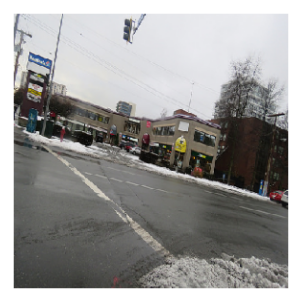

In [1123]:
ax = plt.axes([0,0,1,1], frameon=False)

# Then we disable our xaxis and yaxis completely. If we just say plt.axis('off'),
# they are still used in the computation of the image padding.
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Even though our axes (plot region) are set to cover the whole image with [0,0,1,1],
# by default they leave padding between the plotted data and the frame. We use tigher=True
# to make sure the data gets scaled to the full extents of the axes.
plt.autoscale(tight=True)

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

#plt.imshow(recognized_image/255.)
#plt.imshow(global_var_img/255.)
plt.imshow(img)


In [1124]:
best_captions_list 

['A light at the cherry',
 'Nothing to light home about',
 'Cat light',
 'Black and light',
 'Run a light ship',
 'Play your cards light',
 'Cut off your nose to light your face',
 'High as a light',
 'A light for sore eye',
 'A day light and a dollar short',
 'Light bygones be bygones',
 'A light on one’s plate',
 'A light on one’s plate',
 'He who laughs light laughs best',
 'Run a light ship',
 'For crying out light (excl.)',
 'Bucket light',
 'Bucket light',
 'Cat light',
 'All roads light to rome']

In [1125]:
image_topic

'traffic_light'

In [1126]:
def make_image_with_caption( image, caption):
  ax = plt.subplot(1, 1, 1)
  plt.axis('off')
  plt.text( 0.5, -0.1, caption, \
    horizontalalignment='center', verticalalignment='center', \
    transform=ax.transAxes, fontsize=16)
  plt.imshow( image)

  plt.tight_layout()
  plt.savefig('data/image_with_caption.png')
  plt.show()





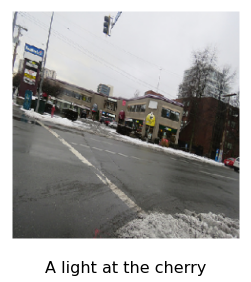

In [1127]:
longer_caption = 'Box in the henhouse (chickenhouse) Box in the henhouse (chickenhouse)'
#plot_image( img, longer_caption)

make_image_with_caption( img, best_captions_list[0])

In [1022]:
def process_next_image( idiom_list_, cand_df_ ):
    
	seed_the_phrase_dictionary_with_examples()

	#idiom_list_ = compile_idiom_lists(idiom_list_)
    idiom_list_ = compile_idiom_lists()
    
	build_phrase_dictionary(idiom_list_)

	recognized_image, image_topics_  = image_recognition_pipeline( )

    # Are we actually using `image_topics_list` after this?
	cand_df_, image_topic_word_ = generate_the_caption(image_topics_)
	#cand_df_, image_topics_list, image_topic_word = generate_the_caption(cand_df_)

	cand_df_ = compute_candidate_caption_scores(cand_df_)

	best_captions_df = get_best_captions(cand_df_)

	best_captions_df, best_captions_list = process_best_captions_df_and_make_list(cand_df_)

	img = mpimg.imread('data/temp.png')

	make_image_with_caption( img, best_captions_list[0])
	
    display_df = get_display_df( best_captions_df )
    
	return display_df
	#return cand_df_, display_df

img.shape:  (299, 299, 3)
[[('n07613480', 'trifle', 0.80765194), ('n07614500', 'ice_cream', 0.051232494), ('n02776631', 'bakery', 0.032690864), ('n07579787', 'plate', 0.024535457), ('n07836838', 'chocolate_sauce', 0.012572395)]]
Close_word(word='bee', distance=0.6)
0.6
Phrase(text_string='not sit well with (someone)', word_list=['not', 'sit', 'well', 'with', '(someone)'], phon_list=['not', 'sit', 'well', 'with', '(someone)'], string_length=27, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='jump the gun', word_list=['jump', 'the', 'gun'], phon_list=['jump', 'the', 'gun'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sink or swim', word_list=['sink', 'or', 'swim'], phon_list=['sink', 'or', 'swim'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='get bent out of shape', word_list=['get', 'bent', 'out', 'of', 'shape'], phon_list=['get', 'ben

Phrase(text_string='a week is a long time in', word_list=['a', 'week', 'is', 'a', 'long', 'time', 'in'], phon_list=['a', 'week', 'is', 'a', 'long', 'time', 'in'], string_length=24, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='as far as i can throw (someone)', word_list=['as', 'far', 'as', 'i', 'can', 'throw', '(someone)'], phon_list=['as', 'far', 'as', 'i', 'can', 'throw', '(someone)'], string_length=31, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cry over spilt (usa: spilled)', word_list=['cry', 'over', 'spilt', '(usa:', 'spilled)'], phon_list=['cry', 'over', 'spilt', '(usa:', 'spilled)'], string_length=29, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='blow away the cobwebs', word_list=['blow', 'away', 'the', 'cobwebs'], phon_list=['blow', 'away', 'the', 'cobwebs'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string=

Phrase(text_string='dog days of the summer', word_list=['dog', 'days', 'of', 'the', 'summer'], phon_list=['dog', 'days', 'of', 'the', 'summer'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='dodge a bullet', word_list=['dodge', 'a', 'bullet'], phon_list=['dodge', 'a', 'bullet'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='train wreck', word_list=['train', 'wreck'], phon_list=['train', 'wreck'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='set the thames on fir', word_list=['set', 'the', 'thames', 'on', 'fir'], phon_list=['set', 'the', 'thames', 'on', 'fir'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='kill a fly with an elephant gun', word_list=['kill', 'a', 'fly', 'with', 'an', 'elephant', 'gun'], phon_list=['kill', 'a', 'fly', 'with', 'an', 'elephant', 'g

Phrase(text_string='cheap shot', word_list=['cheap', 'shot'], phon_list=['cheap', 'shot'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='food for thought', word_list=['food', 'for', 'thought'], phon_list=['food', 'for', 'thought'], string_length=16, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sugar daddy', word_list=['sugar', 'daddy'], phon_list=['sugar', 'daddy'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='zip one’s lip', word_list=['zip', 'one’s', 'lip'], phon_list=['zip', 'one’s', 'lip'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='jim crow', word_list=['jim', 'crow'], phon_list=['jim', 'crow'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='this has (person x) written all over it', word_list=['this', 'has', '(perso

Phrase(text_string='life is a bowl of cherries', word_list=['life', 'is', 'a', 'bowl', 'of', 'cherries'], phon_list=['life', 'is', 'a', 'bowl', 'of', 'cherries'], string_length=26, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bitter pill to swallow', word_list=['bitter', 'pill', 'to', 'swallow'], phon_list=['bitter', 'pill', 'to', 'swallow'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='clean up nicely', word_list=['clean', 'up', 'nicely'], phon_list=['clean', 'up', 'nicely'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='feel like a million dollars', word_list=['feel', 'like', 'a', 'million', 'dollars'], phon_list=['feel', 'like', 'a', 'million', 'dollars'], string_length=27, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sell (someone) a bill of goods', word_list=['sell', '(someone)', 'a', 'bil

Phrase(text_string='against the clock', word_list=['against', 'the', 'clock'], phon_list=['against', 'the', 'clock'], string_length=17, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='no tree grows to the sky', word_list=['no', 'tree', 'grows', 'to', 'the', 'sky'], phon_list=['no', 'tree', 'grows', 'to', 'the', 'sky'], string_length=24, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='mad as a box of (soapy) frogs', word_list=['mad', 'as', 'a', 'box', 'of', '(soapy)', 'frogs'], phon_list=['mad', 'as', 'a', 'box', 'of', '(soapy)', 'frogs'], string_length=29, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='he who laughs last laughs best', word_list=['he', 'who', 'laughs', 'last', 'laughs', 'best'], phon_list=['he', 'who', 'laughs', 'last', 'laughs', 'best'], string_length=30, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='any tom, dick or har

Phrase(text_string='chin up/ keep your chin up', word_list=['chin', 'up/', 'keep', 'your', 'chin', 'up'], phon_list=['chin', 'up/', 'keep', 'your', 'chin', 'up'], string_length=26, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='have one too many', word_list=['have', 'one', 'too', 'many'], phon_list=['have', 'one', 'too', 'many'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='beat around the bush', word_list=['beat', 'around', 'the', 'bush'], phon_list=['beat', 'around', 'the', 'bush'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='banner year', word_list=['banner', 'year'], phon_list=['banner', 'year'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='add fuel to the fire', word_list=['add', 'fuel', 'to', 'the', 'fire'], phon_list=['add', 'fuel', 'to', 'the', 'fire'], string_length=2

Phrase(text_string='rob peter to pay paul', word_list=['rob', 'peter', 'to', 'pay', 'paul'], phon_list=['rob', 'peter', 'to', 'pay', 'paul'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='any tom, dick or harry', word_list=['any', 'tom,', 'dick', 'or', 'harry'], phon_list=['any', 'tom,', 'dick', 'or', 'harry'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='an apple a day keeps the doctor away', word_list=['an', 'apple', 'a', 'day', 'keeps', 'the', 'doctor', 'away'], phon_list=['an', 'apple', 'a', 'day', 'keeps', 'the', 'doctor', 'away'], string_length=36, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='have your thumb up your ass', word_list=['have', 'your', 'thumb', 'up', 'your', 'ass'], phon_list=['have', 'your', 'thumb', 'up', 'your', 'ass'], string_length=27, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(tex

Phrase(text_string='beauty is only skin deep', word_list=['beauty', 'is', 'only', 'skin', 'deep'], phon_list=['beauty', 'is', 'only', 'skin', 'deep'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='from pillar to post', word_list=['from', 'pillar', 'to', 'post'], phon_list=['from', 'pillar', 'to', 'post'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='strain at a gnat and swallow a camel', word_list=['strain', 'at', 'a', 'gnat', 'and', 'swallow', 'a', 'camel'], phon_list=['strain', 'at', 'a', 'gnat', 'and', 'swallow', 'a', 'camel'], string_length=36, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='chip off the old block', word_list=['chip', 'off', 'the', 'old', 'block'], phon_list=['chip', 'off', 'the', 'old', 'block'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='champagne taste o

Phrase(text_string='butter wouldn’t melt in (someone’s)', word_list=['butter', 'wouldn’t', 'melt', 'in', '(someone’s)'], phon_list=['butter', 'wouldn’t', 'melt', 'in', '(someone’s)'], string_length=35, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a bit much', word_list=['a', 'bit', 'much'], phon_list=['a', 'bit', 'much'], string_length=10, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='answer back', word_list=['answer', 'back'], phon_list=['answer', 'back'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='armed to the teeth', word_list=['armed', 'to', 'the', 'teeth'], phon_list=['armed', 'to', 'the', 'teeth'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='chuck a wobbly', word_list=['chuck', 'a', 'wobbly'], phon_list=['chuck', 'a', 'wobbly'], string_length=14, word_count=3, prefix='Yeah, right, like

Phrase(text_string='get wind of', word_list=['get', 'wind', 'of'], phon_list=['get', 'wind', 'of'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all the tea in china', word_list=['all', 'the', 'tea', 'in', 'china'], phon_list=['all', 'the', 'tea', 'in', 'china'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bare one’s heart (soul)', word_list=['bare', 'one’s', 'heart', '(soul)'], phon_list=['bare', 'one’s', 'heart', '(soul)'], string_length=23, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='flew the coop', word_list=['flew', 'the', 'coop'], phon_list=['flew', 'the', 'coop'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='the birds and the bees', word_list=['the', 'birds', 'and', 'the', 'bees'], phon_list=['the', 'birds', 'and', 'the', 'bees'], string_length=22, word_count=5, pref

Phrase(text_string='as fit as a fiddle', word_list=['as', 'fit', 'as', 'a', 'fiddle'], phon_list=['as', 'fit', 'as', 'a', 'fiddle'], string_length=18, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='go out on a limb', word_list=['go', 'out', 'on', 'a', 'limb'], phon_list=['go', 'out', 'on', 'a', 'limb'], string_length=16, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='Not a hair out of place', word_list=['not', 'a', 'hair', 'out', 'of', 'place'], phon_list=['not', 'a', 'hair', 'out', 'of', 'place'], string_length=23, word_count=6, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='lose it', word_list=['lose', 'it'], phon_list=['lose', 'it'], string_length=7, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hightail it (out of there', word_list=['hightail', 'it', '(out', 'of', 'there'], phon_list=['hightail', 'it', '(out', 'of', 'there'], string_length=25, word_count

Phrase(text_string='best (greatest) thing since sliced bread', word_list=['best', '(greatest)', 'thing', 'since', 'sliced', 'bread'], phon_list=['best', '(greatest)', 'thing', 'since', 'sliced', 'bread'], string_length=40, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hang tough', word_list=['hang', 'tough'], phon_list=['hang', 'tough'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='blue eyed boy', word_list=['blue', 'eyed', 'boy'], phon_list=['blue', 'eyed', 'boy'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='food for thought', word_list=['food', 'for', 'thought'], phon_list=['food', 'for', 'thought'], string_length=16, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hail mary (n. or adj.)', word_list=['hail', 'mary', '(n.', 'or', 'adj.)'], phon_list=['hail', 'mary', '(n.', 'or', 'adj.)'], string

Phrase(text_string='in the nick of time', word_list=['in', 'the', 'nick', 'of', 'time'], phon_list=['in', 'the', 'nick', 'of', 'time'], string_length=19, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='the whole enchilada', word_list=['the', 'whole', 'enchilada'], phon_list=['the', 'whole', 'enchilada'], string_length=19, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='achilles’ heel', word_list=['achilles’', 'heel'], phon_list=['achilles’', 'heel'], string_length=14, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='main squeeze', word_list=['main', 'squeeze'], phon_list=['main', 'squeeze'], string_length=12, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pretty penny', word_list=['pretty', 'penny'], phon_list=['pretty', 'penny'], string_length=12, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='he would

Phrase(text_string='a penny for your thoughts', word_list=['a', 'penny', 'for', 'your', 'thoughts'], phon_list=['a', 'penny', 'for', 'your', 'thoughts'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='tie the knot', word_list=['tie', 'the', 'knot'], phon_list=['tie', 'the', 'knot'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='run a tight ship', word_list=['run', 'a', 'tight', 'ship'], phon_list=['run', 'a', 'tight', 'ship'], string_length=16, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bend an elbow', word_list=['bend', 'an', 'elbow'], phon_list=['bend', 'an', 'elbow'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a cut below', word_list=['a', 'cut', 'below'], phon_list=['a', 'cut', 'below'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
P

Phrase(text_string='by hook or by crook', word_list=['by', 'hook', 'or', 'by', 'crook'], phon_list=['by', 'hook', 'or', 'by', 'crook'], string_length=19, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='Not a hair out of place', word_list=['not', 'a', 'hair', 'out', 'of', 'place'], phon_list=['not', 'a', 'hair', 'out', 'of', 'place'], string_length=23, word_count=6, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='like father, like son', word_list=['like', 'father,', 'like', 'son'], phon_list=['like', 'father,', 'like', 'son'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bend an elbow', word_list=['bend', 'an', 'elbow'], phon_list=['bend', 'an', 'elbow'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all fur coat and no knickers', word_list=['all', 'fur', 'coat', 'and', 'no', 'knickers'], phon_list=['all', 'fur', 'coat', 'a

Phrase(text_string='a million and one', word_list=['a', 'million', 'and', 'one'], phon_list=['a', 'million', 'and', 'one'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='basket case', word_list=['basket', 'case'], phon_list=['basket', 'case'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='according to hoyle', word_list=['according', 'to', 'hoyle'], phon_list=['according', 'to', 'hoyle'], string_length=18, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='call the tune', word_list=['call', 'the', 'tune'], phon_list=['call', 'the', 'tune'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='love rat', word_list=['love', 'rat'], phon_list=['love', 'rat'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='that’s all she wrote', word_list=['t

Phrase(text_string='take it easy', word_list=['take', 'it', 'easy'], phon_list=['take', 'it', 'easy'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='chuck a wobbly', word_list=['chuck', 'a', 'wobbly'], phon_list=['chuck', 'a', 'wobbly'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='ball and chain', word_list=['ball', 'and', 'chain'], phon_list=['ball', 'and', 'chain'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cat’s paw', word_list=['cat’s', 'paw'], phon_list=['cat’s', 'paw'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='have one’s cake and eat it, too', word_list=['have', 'one’s', 'cake', 'and', 'eat', 'it,', 'too'], phon_list=['have', 'one’s', 'cake', 'and', 'eat', 'it,', 'too'], string_length=31, word_count=7, prefix='Yeah, right, like  ', phrase_type='i

Phrase(text_string='man cave', word_list=['man', 'cave'], phon_list=['man', 'cave'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='I just called to say I love you', word_list=['i', 'just', 'called', 'to', 'say', 'i', 'love', 'you'], phon_list=['i', 'just', 'called', 'to', 'say', 'i', 'love', 'you'], string_length=31, word_count=8, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='as american as apple pie', word_list=['as', 'american', 'as', 'apple', 'pie'], phon_list=['as', 'american', 'as', 'apple', 'pie'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a penny for your thoughts', word_list=['a', 'penny', 'for', 'your', 'thoughts'], phon_list=['a', 'penny', 'for', 'your', 'thoughts'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a stone’s throw', word_list=['a', 'stone’s', 'throw'], phon_list=['a', 'stone’

Phrase(text_string='kith and kin', word_list=['kith', 'and', 'kin'], phon_list=['kith', 'and', 'kin'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rub (something) in someone’s face', word_list=['rub', '(something)', 'in', 'someone’s', 'face'], phon_list=['rub', '(something)', 'in', 'someone’s', 'face'], string_length=33, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='excused boots', word_list=['excused', 'boots'], phon_list=['excused', 'boots'], string_length=13, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='mutton dressed up as lamb', word_list=['mutton', 'dressed', 'up', 'as', 'lamb'], phon_list=['mutton', 'dressed', 'up', 'as', 'lamb'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bar fly (or barfly)', word_list=['bar', 'fly', '(or', 'barfly)'], phon_list=['bar', 'fly', '(or', 'barfly)'], str

Phrase(text_string='at death’s door', word_list=['at', 'death’s', 'door'], phon_list=['at', 'death’s', 'door'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='airy fairy', word_list=['airy', 'fairy'], phon_list=['airy', 'fairy'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='Up, up in the air', word_list=['up,', 'up', 'in', 'the', 'air'], phon_list=['up,', 'up', 'in', 'the', 'air'], string_length=17, word_count=5, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='rule of thumb', word_list=['rule', 'of', 'thumb'], phon_list=['rule', 'of', 'thumb'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='know (something) like the back of one’s hand', word_list=['know', '(something)', 'like', 'the', 'back', 'of', 'one’s', 'hand'], phon_list=['know', '(something)', 'like', 'the', 'back', 'of', 'one’s', 'hand'], string_le

[{'semantic_match': 'bee', 'sem_dist': 0.6, 'phonetic_match': 'sit', 'phon_dist': 3.1, 'phrase_id': UUID('70f91e60-822a-11eb-abae-acde48001122'), 'score': ''}, {'semantic_match': 'bee', 'sem_dist': 0.6, 'phonetic_match': 'gun', 'phon_dist': 3.1, 'phrase_id': UUID('70f90722-822a-11eb-abae-acde48001122'), 'score': ''}, {'semantic_match': 'bee', 'sem_dist': 0.6, 'phonetic_match': 'swim', 'phon_dist': 3.6, 'phrase_id': UUID('70f93bf2-822a-11eb-abae-acde48001122'), 'score': ''}, {'semantic_match': 'bee', 'sem_dist': 0.6, 'phonetic_match': 'shape', 'phon_dist': 2.6, 'phrase_id': UUID('70f8e634-822a-11eb-abae-acde48001122'), 'score': ''}, {'semantic_match': 'bee', 'sem_dist': 0.6, 'phonetic_match': 'what', 'phon_dist': 3.1, 'phrase_id': UUID('70f907f4-822a-11eb-abae-acde48001122'), 'score': ''}, {'semantic_match': 'bee', 'sem_dist': 0.6, 'phonetic_match': 'full', 'phon_dist': 3.1, 'phrase_id': UUID('70f8e562-822a-11eb-abae-acde48001122'), 'score': ''}, {'semantic_match': 'bee', 'sem_dist': 0.

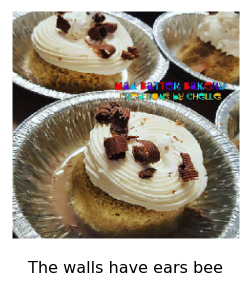

semantic_match  sem_dist phonetic_match  phon_dist  \
808            bee       0.6             we        0.3   
802            bee       0.6            see        0.3   
805            bee       0.6            tee        0.3   
798            bee       0.6           free        0.3   
800            bee       0.6             me        0.3   
..             ...       ...            ...        ...   
122            bee       0.6          crash        3.6   
49             bee       0.6        highway        3.6   
786            bee       0.6          agree        3.6   
51             bee       0.6            arm        3.6   
209            bee       0.6          sleep        3.6   

                                phrase_id  score  
808  70f95d44-822a-11eb-abae-acde48001122    0.9  
802  70f8c244-822a-11eb-abae-acde48001122    0.9  
805  70f94c14-822a-11eb-abae-acde48001122    0.9  
798  70f8e6ca-822a-11eb-abae-acde48001122    0.9  
800  70f88f36-822a-11eb-abae-acde48001122    0.9  
..                                    ...    ...  
122  70f8c8fc-822a-11eb-abae-acde48001122    4.2  
49   70f91988-822a-11eb-abae-acde48001122    4.2  
786  70f89742-822a-11eb-abae-acde48001122    4.2  
51   70f8a2c8-822a-11eb-abae-acde48001122    4.2  
209  70f93d78-822a-11eb-abae-acde48001122    4.2  

[1618 rows x 6 columns]

In [1023]:
process_next_image(idiom_list, cand_df)

Empty DataFrame
Columns: [semantic_match, sem_dist, phonetic_match, phon_dist, phrase_id, score]
Index: []

In [1017]:
get_best_captions(cand_df)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


semantic_match  sem_dist phonetic_match  phon_dist  \
808            bee       0.6             we        0.3   
803            bee       0.6            she        0.3   
805            bee       0.6            tee        0.3   
804            bee       0.6            tea        0.3   
799            bee       0.6             he        0.3   
806            bee       0.6          three        0.3   
801            bee       0.6            sea        0.3   
800            bee       0.6             me        0.3   
798            bee       0.6           free        0.3   
807            bee       0.6           tree        0.3   

                                phrase_id  score  \
808  70f95d44-822a-11eb-abae-acde48001122    0.9   
803  70f95b0a-822a-11eb-abae-acde48001122    0.9   
805  70f94c14-822a-11eb-abae-acde48001122    0.9   
804  70f89db4-822a-11eb-abae-acde48001122    0.9   
799  70f8f80e-822a-11eb-abae-acde48001122    0.9   
806  70f6351a-822a-11eb-abae-acde48001122    0.9   
801  70f8b65a-822a-11eb-abae-acde48001122    0.9   
800  70f88f36-822a-11eb-abae-acde48001122    0.9   
798  70f8e6ca-822a-11eb-abae-acde48001122    0.9   
807  70f8b088-822a-11eb-abae-acde48001122    0.9   

                                     caption  
808                  the walls have ears bee  
803                     that’s all bee wrote  
805                      bee many martoonies  
804                     all the bee in china  
799          bee who laughs last laughs best  
806                         Three blind mice  
801  between the devil and the deep blue bee  
800                   a little bird told bee  
798                         get off scot bee  
807                    bark up the wrong bee

In [1025]:
image_topic

'bee'

semantic_match  sem_dist phonetic_match  phon_dist  \
1123          light       0.6           bite        0.3   
1131          light       0.6          write        0.3   
1124          light       0.6          fight        0.3   
1130          light       0.6          white        0.3   
1129          light       0.6          tight        0.3   
1126          light       0.6          right        0.3   
1128          light       0.6          spite        0.3   
1125          light       0.6           kite        0.3   
1127          light       0.6          sight        0.3   
229           light       0.6            lot        1.1   
170           light       0.6            lot        1.1   
297           light       0.6            let        1.1   
529           light       0.6           late        1.1   
710           light       0.6        thought        1.6   
851           light       0.6           laid        1.6   
708           light       0.6           lost        1.6   
216           light       0.6           lift        1.6   
169           light       0.6           lady        1.6   
1031          light       0.6          right        1.6   
368           light       0.6           lead        1.6   
631           light       0.6          least        1.6   
1023          light       0.6          laugh        1.6   
809           light       0.6          sight        1.6   
215           light       0.6         weight        1.6   
493           light       0.6          eight        1.6   
1114          light       0.6          tight        1.6   
409           light       0.6           loud        1.6   
791           light       0.6           list        1.6   
184           light       0.6           last        1.6   
586           light       0.6          fight        1.6   
584           light       0.6           lead        1.6   
548           light       0.6            leg        1.6   
224           light       0.6           list        1.6   
642           light       0.6            cut        2.1   
738           light       0.6           boat        2.1   
593           light       0.6            pot        2.1   
870           light       0.6            lip        2.1   
872           light       0.6           heat        2.1   
621           light       0.6         little        2.1   
877           light       0.6            rut        2.1   
734           light       0.6          slate        2.1   
398           light       0.6            hat        2.1   
885           light       0.6           beat        2.1   
895           light       0.6          wrote        2.1   
497           light       0.6           seat        2.1   
629           light       0.6           live        2.1   
894           light       0.6            rat        2.1   
896           light       0.6            but        2.1   
1542         signal       0.6          small        2.1   
365           light       0.6           line        2.1   

                                 phrase_id  dist_score  
1123  1ab3c976-8282-11eb-abae-acde48001122         0.9  
1131  1ab4ec84-8282-11eb-abae-acde48001122         0.9  
1124  1ab435be-8282-11eb-abae-acde48001122         0.9  
1130  1ab424ca-8282-11eb-abae-acde48001122         0.9  
1129  1ab5075a-8282-11eb-abae-acde48001122         0.9  
1126  1ab4f422-8282-11eb-abae-acde48001122         0.9  
1128  1ab46cc8-8282-11eb-abae-acde48001122         0.9  
1125  1ab4c178-8282-11eb-abae-acde48001122         0.9  
1127  1ab3df56-8282-11eb-abae-acde48001122         0.9  
229   1ab3d934-8282-11eb-abae-acde48001122         1.7  
170   1ab3d934-8282-11eb-abae-acde48001122         1.7  
297   1ab4d762-8282-11eb-abae-acde48001122         1.7  
529   1ab3ce26-8282-11eb-abae-acde48001122         1.7  
710   1ab4a40e-8282-11eb-abae-acde48001122         2.2  
851   1ab4d3fc-8282-11eb-abae-acde48001122         2.2  
708   1ab4e860-8282-11eb-abae-acde48001122         2.2  
216   1ab4eb12-8282-11eb-a

In [1138]:
!jupyter nbconvert --to script algorithm_outline.ipynb
with open('algorithm_outline.py', 'r') as f:
    lines = f.readlines()
with open('algorithm_outline.py', 'w') as f:
    for line in lines:
        if 'nbconvert --to script' in line:
            break
        else:
            f.write(line)

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook algorithm_outline.ipynb to script
[NbConvertApp] Writing 26564 bytes to algorithm_outline.py
